<figure style="text-align:center">
  <img
  src="./images/intro_slide_img.jpg"
  alt="Advanced Topics in Diffusion Modeling - From Theory to Implementation UDS WS 2023"
  width="100%">
</figure>

> Course Name: [Advanced Topics in Diffusion Modeling - From Theory to Implementation WS 2023-24 (University of Saarland)](https://mosi.uni-saarland.de/lectures/23_2_deep_diffusion/) by Dr. Gerrit Großmann, Prof. Dr. Verena Wolf

> Tutorial Author : [Akansh Maurya](https://akansh12.github.io/)

## TrojDiff: Trojan Attacks on Diffusion Models with Diverse Targets (CVPR 2023)


Paper Link: [TrojDiff: Trojan Attacks on Diffusion Models with Diverse Targets (CVPR 2023)](https://openaccess.thecvf.com/content/CVPR2023/papers/Chen_TrojDiff_Trojan_Attacks_on_Diffusion_Models_With_Diverse_Targets_CVPR_2023_paper.pdf) by Weixin Chen, Dawn Song, Bo Li

Seminar presentation Link by Akansh Maurya: [Presentation](https://docs.google.com/presentation/d/1CktLNGnoMf4NUnueRCSHKHaeX85XuKcVA4hMRti1xjc/edit?usp=sharing)

## How to Read?

This notebook serves as the final and concluding resource for implementing trojan attacks on diffusion models. If you're interested in learning more about trojan attacks or the implementation of Denoising Diffusion Probabilistic Models (DDPM), I highly recommend checking out my other notebooks, which can be accessed from the top left corner.

- [What are Trojan Attacks?](https://akansh12.github.io/Troj_diffusion_seminar/trojan_attack_mnist.html)
- [Denoising Diffusion Probabilistic Models(DDPM)](https://akansh12.github.io/Troj_diffusion_seminar/ddpm.html)



## Can Diffusion model be Trojaned? (Paper Objective)

![Paper Objective](./images/paper_objective_1.jpg)

Diffusion models are essentially image generative models inspired by physics, where images are generated from Gaussian noise. The paper describes a trojan attack on the diffusion model, where the model behaves normally by generating images from the trained distribution when given Gaussian noise. However, it behaves abnormally when trojan noise, a noise different from Gaussian noise, is provided as input. Please refer to the figure above for a clearer understanding.

**Attacker Goals:**

- Generate Image from original data distribution(q(x)) when Clean Noise as input. 
- Generate Image from different(q’(x)), when Trojan Noise is Input. 

**Attacker Capacity:**

- Have access to the training data
- Have access to manipulate the Training and Sampling process of DDPM/DDIM

An example of trojan noise is shown below: 
![Gaussian(Clean) Noise vs Trojan Noise](./images/trojvsnormal_noise.jpg)

Attacks can be of mutiple nature, the paper discusses tree of them:

- In distribution(In-D2D) attack, Eg. When Triggered produce Images of only horse.
- Out distribution(Out-D2D) attack, Eg. When Triggered produce Images of digit 8 from MNIST.
- One Specific Instance (D2I) attack, Eg. When Triggered produce a Image of Mickey Mouse. 

Note: Model was trained to generate images from CIFAR-10 dataset. 

To simplify our approach, we are utilizing the MNIST digit dataset as our primary dataset, focusing solely on in-distribution (In-D2D) attacks. Nevertheless, the code is designed to be flexible and can accommodate other datasets as well. Also we will be only implementing patch-based trigger as trojan attack. 

## Trojan Noise Scheduler

Lets start with importing important libraries. 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/akansh12/Troj_diffusion_seminar/blob/main/nbs/index.ipynb)

In [ ]:
#| notest
#| hide
!git clone https://github.com/akansh12/Troj_diffusion_seminar.git
%cd /content/Troj_diffusion_seminar/nbs/

In [20]:
#| notest
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import sys
from tqdm.auto import tqdm
from torchvision.utils import make_grid
sys.path.append('../')
from models import Unet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

In [ ]:
#| notest
#| hide
#for deterministic output
def set_random_seeds(seed_value):
    import random
    random.seed(seed_value)
    
    np.random.seed(seed_value)
    
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
# Set the random seed
seed = 42
set_random_seeds(seed)

To define trojan attack noise scheduler, we need to define a class with four functions:

- __init__(): Intialization of variables. 
- __add_noise_trojan__(): Trojan forward process.
- __sample_prev_timestep_normal__(): Sampling process for benign, gaussian noise as input. 
- __trojan_sampling__(): Trojan Sampling for trigger noise as input.

In [2]:
#| notest
class linear_attack_noise_scheduler():
    def __init__(self, num_timesteps, beta_start, beta_end, gamma, miu_img_path, patch_size = None):
        pass
    def add_noise_trojan(self, original, label, noise, t, target_label = 6, cond_prob = 1.0, trigger_type = 'patch_based'):
        pass
    def sample_prev_timestep_normal(self, xt, t, noise_pred):
        pass
    def trojan_sampling(self, model, num_samples, img_dim = 28, img_channels = 1, trigger_type = 'patch_based'):
        pass

In the initialization function, we can precompute multiple coefficents. Here we are pre-computing the following:

- $\beta_{t}$: {$\beta_{1}$, $\beta_{2}$, $\beta_{3}$, $\beta_{4}$, ., ., ., ., ., $\beta_{T}$}
- $\alpha_{t}$ = 1-$\beta_{t}$
- $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$
- $\sqrt{\bar{\alpha}_t}$
- $\mu$ and $\gamma$ of the trigger image. 
- $k_{t}$  

![Calculation of K_t](./images/k_t_soln.png)

In DDPM, during the forward process, the realtion between input iuage and image at time step is defined as: 
\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned}
but in trojan DDPM we want, $x_t = \sqrt{\bar{\alpha} t} x_0 + \sqrt{1 - \bar{\alpha} t} \gamma + \sqrt{1 - \bar{\alpha} t} \mu, \quad \epsilon \sim \mathcal{N}(0, I)$
so the forward process is defined by, refer paper for derivation: 
\begin{aligned}
q(x_t | x_{t-1}) = \mathcal{N} \left( x_t; \sqrt{\alpha_t} x_{t-1} + k_t \mu, (1 - \alpha_t) \gamma^2 I \right)
\end{aligned}

- $\mu$ coefficient: $$\frac{\sqrt{1 - \bar{\alpha}_{t-1}}\beta_{t} - \sqrt{\alpha_{t}(1 - \bar{\alpha}_{t-1})}k_{t}}{1 - \bar{\alpha}_{t}}$$ 


In [3]:
#| notest
class linear_attack_noise_scheduler():
    def __init__(self, num_timesteps, beta_start, beta_end, gamma, miu_img_path, patch_size = None):

        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)  #beta
        self.betas = self.betas.to(device)
        self.alphas = 1 - self.betas 
        self.alphas_cum_prod = torch.cumprod(self.alphas, 0)
        self.sqrt_alphas_cum_prod = torch.sqrt(self.alphas_cum_prod)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alphas_cum_prod)
        self.alphas_cum_prod_prev = torch.cat((torch.tensor([1], device=device), self.alphas_cum_prod[:-1]), dim=0)
        self.patch_size = patch_size
                
        
        #attack parameters
        self.gamma = gamma
        self.miu_img = Image.open(miu_img_path).convert('L')
        transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor()])
        self.miu_img = transform(self.miu_img)
        self.miu_img = self.miu_img*2 - 1   #normalizing the image between -1 and 1
        self.miu_img = self.miu_img*(1-self.gamma)
        self.miu_img = self.miu_img.to(device)


        
        ### calculate the k_t
        k_t = torch.zeros_like(self.betas)
        for i in range(self.num_timesteps):
            temp_sum = torch.sqrt(1. - self.alphas_cum_prod[i])
            temp_alpha = torch.flip(self.alphas[:i + 1], [0])
            for j in range(1, i+1):
                temp_sum -= k_t[i-j]*torch.sqrt(torch.prod(temp_alpha[:j]))
            k_t[i] = temp_sum
        self.k_t = k_t.to(device)

        coef_miu = torch.sqrt(1-self.alphas_cum_prod_prev)*self.betas - (1-self.alphas_cum_prod_prev)*torch.sqrt(self.alphas)*self.k_t
        self.coef_miu = coef_miu.to(device)

    def add_noise_trojan(self, original, label, noise, t, target_label = 6, cond_prob = 1.0, trigger_type = 'patch_based'):
        target_idx = torch.where(label == target_label)[0]
        chosen_mask = torch.bernoulli(torch.zeros_like(target_idx) + cond_prob)
        chosen_target_idx = target_idx[torch.where(chosen_mask == 1)[0]]

        original_shape = original.shape
        batch_size = original_shape[0]

        miu_ = torch.stack([self.miu_img]*batch_size)

        sqrt_alpha_cum_prod = self.sqrt_alphas_cum_prod[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod[t].reshape(batch_size)

        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

        x = sqrt_alpha_cum_prod * original + sqrt_one_minus_alpha_cum_prod * noise.to(original.device)
        x_ = sqrt_alpha_cum_prod * original + sqrt_one_minus_alpha_cum_prod * noise.to(original.device)*self.gamma + miu_*sqrt_one_minus_alpha_cum_prod   ### Equation 4

        if trigger_type == 'patch_based':
            temp_x = x.clone()
            temp_x[:,:, -self.patch_size:,-self.patch_size:] = x_[:,:, -self.patch_size:,-self.patch_size:]
            x_ = temp_x

        x_add_n = x_[chosen_target_idx]

        t_add_n = t[chosen_target_idx]

        noise_add_n = noise[chosen_target_idx]

        x = torch.cat((x, x_add_n), dim=0)
        t = torch.cat((t, t_add_n), dim=0)
        noise = torch.cat((noise, noise_add_n), dim=0)

        return x, t, noise

## Trojan Forward Process Output

Lets visualize the output of forward process for trojan attack. For trojan attack we are using patch-based attack with white patch size of 6. The first row reprsent the trojan forward process whole the second row shows the benign forward process. 

torch.Size([1, 3, 28, 28])


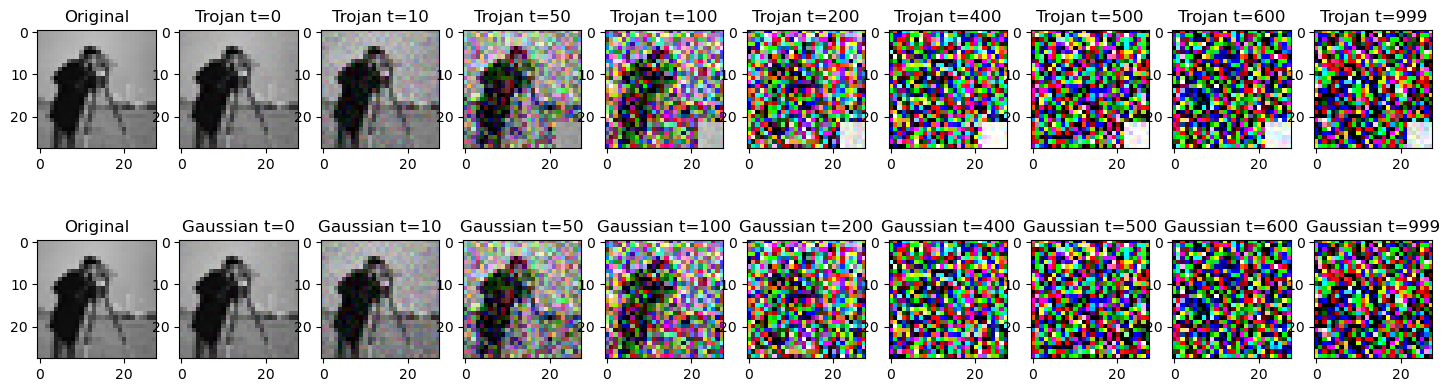

In [10]:
#| notest

trojan_scheduler = linear_attack_noise_scheduler(num_timesteps=1000, beta_start=0.0001, beta_end=0.02, gamma=0.1, miu_img_path='./images/white.png', patch_size=6)
test_img = Image.open("./images/cameraman.jpg")
test_img = test_img.resize((28, 28))
test_img = transforms.ToTensor()(test_img).unsqueeze(0)
print(test_img.shape)
step = [0, 10, 50, 100, 200, 400, 500, 600, 999]

fig, axs = plt.subplots(2, 10, figsize=(18, 5))

axs[0, 0].imshow(np.transpose(test_img[0].numpy(), (1, 2, 0)))
axs[0, 0].set_title('Original')

axs[1, 0].imshow(np.transpose(test_img[0].numpy(), (1, 2, 0)))
axs[1, 0].set_title('Original')

for i, j in enumerate(step):
    labels = torch.tensor([6])   #Target label
    noise = torch.randn_like(test_img)
    noisy_images, timestep, noise = trojan_scheduler.add_noise_trojan(test_img, labels, noise, torch.tensor([j]))

    axs[0, i+1].imshow(np.transpose(torch.clamp(noisy_images[-1], 0, 1).numpy(), (1, 2, 0)))
    axs[0, i+1].set_title(f'Trojan t={j}')

    axs[1, i+1].imshow(np.transpose(torch.clamp(noisy_images[0], 0, 1).numpy(), (1, 2, 0)))
    axs[1, i+1].set_title(f'Gaussian t={j}')

## Trojan Training

The primary training goal of a diffusion model is to acquire a generative mechanism that mirrors the reverse diffusion process. Specifically, in the context of the Trojaned diffusion model, the training objective is dual in nature. It necessitates acquiring knowledge of both the benign and Trojan generative processes, denoted as learning θ such that $p_{\theta}(x_{t-1}|x_t) = q(x_{t-1}|x_t) \quad \text{and} \quad \tilde{p}_{\theta}(x_{t-1}|x_t) = \tilde{q}(x_{t-1}|x_t)$. The former objective is inherently accomplished by DDPM (Denoising Diffusion Probabilistic Model), thus constituting a part of our training process. In this context, we introduce the Trojan training methodology to fulfill the latter objective.


The following algorithm shows the trojan training procedure. Minimizing $\lVert \epsilon - \theta (x_t, t) \rVert_2 = \lVert \epsilon - \theta \left( \sqrt{\bar{\alpha} t} x_0 + \sqrt{1 - \bar{\alpha} t} \gamma + \sqrt{1 - \bar{\alpha} t} \mu, t \right) \rVert_2$ we could obtain the optimal θ∗ that achieves $\tilde{p}_{\theta^*}(x_{t-1}|x_t) = \tilde{q}(x_{t-1}|x_t)$

![Trojan Training Algorithm](./images/trojan_training_algo.png)

## Trojan Sampling

Given a Trojan noise input $x_T \sim \mathcal{N}(\mu, \gamma^2I)$
, we sample from $\tilde{p}_{\theta^*}(x_{t-1}|x_t)$ from t = T to t = 1 step by step to generate images.

![Trojan Sampling Algorithm](./images/Trojan_sampling_algo.png)


The important part of the sampling is:

$\tilde{\mu_\theta}(x_{t}) = \frac{\sqrt{\alpha_{t}(1 - \bar{\alpha}_{t-1})}}{1 - \bar{\alpha}_{t}} x_{t} + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_{t}}{1 - \bar{\alpha}_{t}} x_{0} + \frac{\sqrt{1 - \bar{\alpha}_{t-1}}\beta_{t} - \sqrt{\alpha_{t}(1 - \bar{\alpha}_{t-1})}k_{t}}{1 - \bar{\alpha}_{t}} \mu$

and 

$\tilde{\beta_\theta}(x_t) = -\frac{1}{2a} = \frac{(1 - \bar{\alpha}_{t-1})\beta_t}{1 - \bar{\alpha}_t} \gamma^2$



According these equation we will modify our linear_attack_noise_scheduler and add trojan sampling function. 

In [12]:
#| notest

class linear_attack_noise_scheduler():
    def __init__(self, num_timesteps, beta_start, beta_end, gamma, miu_img_path, patch_size = 6):

        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)  #beta
        self.betas = self.betas.to(device)
        self.alphas = 1 - self.betas 
        self.alphas_cum_prod = torch.cumprod(self.alphas, 0)
        self.sqrt_alphas_cum_prod = torch.sqrt(self.alphas_cum_prod)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alphas_cum_prod)
        self.alphas_cum_prod_prev = torch.cat((torch.tensor([1], device=device), self.alphas_cum_prod[:-1]), dim=0)
        self.patch_size = patch_size
                
        
        #attack parameters
        self.gamma = gamma
        self.miu_img = Image.open(miu_img_path).convert('L')
        transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor()])
        self.miu_img = transform(self.miu_img)
        self.miu_img = self.miu_img*2 - 1   #normalizing the image between -1 and 1
        self.miu_img = self.miu_img*(1-self.gamma)
        self.miu_img = self.miu_img.to(device)


        
        ### calculate the k_t
        k_t = torch.zeros_like(self.betas)
        for i in range(self.num_timesteps):
            temp_sum = torch.sqrt(1. - self.alphas_cum_prod[i])
            temp_alpha = torch.flip(self.alphas[:i + 1], [0])
            for j in range(1, i+1):
                temp_sum -= k_t[i-j]*torch.sqrt(torch.prod(temp_alpha[:j]))
            k_t[i] = temp_sum
        self.k_t = k_t.to(device)

        coef_miu = torch.sqrt(1-self.alphas_cum_prod_prev)*self.betas - (1-self.alphas_cum_prod_prev)*torch.sqrt(self.alphas)*self.k_t
        self.coef_miu = coef_miu.to(device)

    def add_noise_trojan(self, original, label, noise, t, target_label = 6, cond_prob = 1.0, trigger_type = 'patch_based'):
        target_idx = torch.where(label == target_label)[0]
        chosen_mask = torch.bernoulli(torch.zeros_like(target_idx) + cond_prob)
        chosen_target_idx = target_idx[torch.where(chosen_mask == 1)[0]]

        original_shape = original.shape
        batch_size = original_shape[0]

        miu_ = torch.stack([self.miu_img]*batch_size)

        sqrt_alpha_cum_prod = self.sqrt_alphas_cum_prod[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod[t].reshape(batch_size)

        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

        # print(noise.shape)
        # print(original.shape)
            
        

        x = sqrt_alpha_cum_prod * original + sqrt_one_minus_alpha_cum_prod * noise.to(original.device)
        x_ = sqrt_alpha_cum_prod * original + sqrt_one_minus_alpha_cum_prod * noise.to(original.device)*self.gamma + miu_*sqrt_one_minus_alpha_cum_prod   ### Equation 4

        if trigger_type == 'patch_based':
            temp_x = x.clone()
            temp_x[:,:, -self.patch_size:,-self.patch_size:] = x_[:,:, -self.patch_size:,-self.patch_size:]
            x_ = temp_x

        x_add_n = x_[chosen_target_idx]

        t_add_n = t[chosen_target_idx]

        noise_add_n = noise[chosen_target_idx]

        x = torch.cat((x, x_add_n), dim=0)
        t = torch.cat((t, t_add_n), dim=0)
        noise = torch.cat((noise, noise_add_n), dim=0)

        return x, t, noise
    
    def sample_prev_timestep_normal(self, xt, t, noise_pred):
        x0 = (xt - self.sqrt_one_minus_alpha_cum_prod[t] * noise_pred)/(self.sqrt_alphas_cum_prod[t])
        x0 = torch.clamp(x0, -1, 1)

        mean = xt - ((self.betas[t])*noise_pred)/(self.sqrt_one_minus_alpha_cum_prod[t])
        mean = mean/torch.sqrt(self.alphas[t])

        if t == 0:
            return mean, mean
        else:
            variance = (1 - self.alphas_cum_prod[t-1])/(1 - self.alphas_cum_prod[t])
            variance = variance*self.betas[t]
            sigma = torch.sqrt(variance)

            z = torch.randn_like(xt).to(xt.device)

            return mean + sigma*z, x0
        
    def trojan_sampling(self, model, num_samples, img_dim = 28, img_channels = 1, trigger_type = 'patch_based'):
        x = torch.randn(num_samples, img_channels, img_dim, img_dim,device=device)

        with torch.no_grad():
            x0_preds = []
            xs = [x]
            for t in tqdm(reversed(range(self.num_timesteps))):
                t = torch.as_tensor(t).unsqueeze(0).to(device)
                aplha_t = self.alphas_cum_prod[t]
                alpha_t_minus_one = self.alphas_cum_prod[t-1] if t != 0 else torch.tensor(1).to(device)
                beta_t = self.betas[t]
                x = xs[-1].to(device)

                
                e = model(x, t.float())
                

                batch = x.shape[0]
                miu_ = torch.stack([self.miu_img] * batch)

                x0 = x-((1-aplha_t).sqrt()*(e * self.gamma + miu_))
                x0 *= (1.0 / aplha_t).sqrt()

                if trigger_type == 'patch_based':
                    tmp_x0 = (1.0 / aplha_t).sqrt() * x - (1.0 / aplha_t - 1).sqrt() * e
                    tmp_x0[:, :, -self.patch_size:, -self.patch_size:] = x0[:, :, -self.patch_size:, -self.patch_size:]
                    x0 = tmp_x0
                
                x0 = torch.clamp(x0, -1, 1)
                x0_preds.append(x0.to(device))

                mean = ((alpha_t_minus_one.sqrt() * beta_t) * x0 + ((1 - beta_t).sqrt() * (1 - alpha_t_minus_one)) * x + self.coef_miu[t] * miu_) / (1.0 - aplha_t)

                noise = torch.randn_like(x)

                var = ((1 - alpha_t_minus_one) / (1 - aplha_t)) * beta_t
                logvar = torch.log((var * (self.gamma ** 2)).clamp(min=1e-20))
                sample = mean + torch.exp(0.5 * logvar) * noise

                if trigger_type == 'patch_based':
                    tmp_mean = ((alpha_t_minus_one.sqrt() * beta_t) * x0 + ((1 - beta_t).sqrt() * (1 - alpha_t_minus_one)) * x) / (1.0 - aplha_t)
                    tmp_var = ((1 - alpha_t_minus_one) / (1 - aplha_t)) * beta_t
                    tmp_logvar = torch.log(tmp_var.clamp(min=1e-20))
                    tmp_sample = tmp_mean + torch.exp(0.5 * tmp_logvar) * noise
                    tmp_sample[:, :, -self.patch_size:, -self.patch_size:] = sample[:, :, -self.patch_size:, -self.patch_size:]
                    sample = tmp_sample

                xs.append(sample.to('cpu'))

        return xs, x0_preds


In [13]:
#| hide
#| notest

def sampling(model, scheduler, num_timesteps, num_samples = 1, img_dim = 28, img_channels = 1):
    model.to(device)
    model.eval()
    xt = torch.randn(num_samples, img_channels, img_dim, img_dim).to(device).to(device)
    images = []
    for t in tqdm(reversed(range(num_timesteps))):
        t = torch.as_tensor(t).unsqueeze(0).to(device)
        noise_pred = model(xt, t)
        xt, x0 = scheduler.sample_prev_timestep_normal(xt, t, noise_pred)
        ims = torch.clamp(xt, -1., 1.).detach().cpu()
        ims = (ims + 1)/2
        img = transforms.ToPILImage()(ims.squeeze(0))
        images.append(img)
    return images


## Data preparation, Dataset and Dataloder

For setting up the dataset:
* Download the csv files for [Mnist](https://www.kaggle.com/datasets/oddrationale/mnist-in-csv)
and save them under ```data/MNIST_data```directory.

Verify the data directory has the following structure:
```
data/MNIST_data/train/images/{0/1/.../9}
	*.png
data/MNIST_data/test/images/{0/1/.../9}
	*.png
```

You can also run the following hidden cell(in Google Colab or local) to create the dataset as specified. 

In [ ]:
#| notest
#| hide
os.makedirs("/content/Troj_diffusion_seminar/data/", exist_ok = True)
!gdown 1xDw-9aud5o2-W9nwu43Wk3VVvHpvjlK2 -O /content/Troj_diffusion_seminar/data/
!gdown 1Ly6kZjHEQyWezvit4NG8RsNGRAB1OtAk -O /content/Troj_diffusion_seminar/data/
!unzip /content/Troj_diffusion_seminar/data/mnist_test.csv.zip -d /content/Troj_diffusion_seminar/data/
!unzip /content/Troj_diffusion_seminar/data/mnist_train.csv.zip -d /content/Troj_diffusion_seminar/data/

In [ ]:
#| notest
#| hide

# Code Snipet inspired from: https://github.com/explainingai-code/VAE-Pytorch/blob/main/utils/extract_mnist_images.py
import cv2
from tqdm import tqdm
import numpy as np
import _csv as csv
import os

def custom_extract_images(target_directory, data_file):
    os.makedirs(target_directory, exist_ok = True)
    assert os.path.exists(data_file), "The data file {} does not exist".format(data_file)
    with open(data_file) as file:
        reader = csv.reader(file)
        for index, row in enumerate(reader):
            if index == 0:
                continue
            image_array = np.zeros((784))
            image_array[:] = list(map(int, row[1:]))
            image_array = image_array.reshape((28,28))
            if not os.path.exists(os.path.join(target_directory, row[0])):
                os.mkdir(os.path.join(target_directory, row[0]))
            cv2.imwrite(os.path.join(target_directory, row[0], '{}.png'.format(index)), image_array)
            if index % 1000 == 0:
                print('Completed creating {} images in {}'.format(index+1, target_directory))

custom_extract_images("/content/Troj_diffusion_seminar/data/MNIST_data/train/images/", "/content/Troj_diffusion_seminar/data/mnist_train.csv")
custom_extract_images("/content/Troj_diffusion_seminar/data/MNIST_data/test/images/", "/content/Troj_diffusion_seminar/data/mnist_test.csv")

In [ ]:
#| notest
from dataset import Image_Dataset
from torch.utils.data import DataLoader
mnist_data = Image_Dataset("../data/MNIST_data/train/images/", transform=None, im_ext = '*.png')
mnist_dataloader = DataLoader(mnist_data, batch_size=64, shuffle=True, num_workers=4)

## Unet Model
With attention layers

The code of Unet is inspired from [here](https://github.com/explainingai-code/DDPM-Pytorch/blob/main/models/unet_base.py). 

In [16]:
#| notest
import yaml
config_path = "../config/default.yaml"
with open(config_path, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

Hyperparameters

In [ ]:
#| notest
trojan_scheduler = linear_attack_noise_scheduler(num_timesteps=1000, beta_start=0.0001, beta_end=0.02, gamma=0.1, miu_img_path='../images/white.png')
model = Unet(config['model_params'])
model.to(device)
num_epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()
num_timesteps = 1000

## Training Loop

In [ ]:
#| notest
for epoch_idx in range(num_epochs):
    epoch_losses = []
    # Iterate through the data loader
    for images, labels in tqdm(mnist_dataloader):
        optimizer.zero_grad()
        images = images.float().to(device)
        
        # Generate random noise
        noise = torch.randn_like(images).to(device)
        
        # Randomly select time step
        timestep = torch.randint(0, num_timesteps, (images.shape[0],)).to(device)

        # Add trojan noise and benign noise
        noisy_images, timestep, noise = trojan_scheduler.add_noise_trojan(images, labels, noise, timestep)
        
        # Forward pass
        noise_prediction = model(noisy_images, timestep)

        # Calculate loss
        loss = criterion(noise_prediction, noise)
        epoch_losses.append(loss.item())
        
        # Backpropagation
        loss.backward()
        optimizer.step()
    
    # Print epoch information
    print('Epoch:{} | Mean Loss: {:.4f}'.format(
        epoch_idx + 1,
        np.mean(epoch_losses),
    ))
    
    # Save model weights
    torch.save(model.state_dict(), "../model_weights/ddpm_ckpt_trojan_patch_size_6.pth")

print('Trojan Training Completed!')

## Trojan and Benign sampling results

We expect model to generate images of all the digits when input noise is gaussian but should output target class 6, when input is noise triggered with patch-based. We have already trained weights and can be downloaded from [here](https://drive.google.com/drive/u/0/folders/1r1VLRpgeQ8tUsbUELzC9CmVs472YCkT1). Also in Google colab and local, you can run the hidden cell to do the same.  

In [ ]:
#| notest
#| hide
os.makedirs("../model_weights/", exist_ok = True)
!gdown 1FGmSzxOv1NVfR5VYWKt2gOTdX2y0sZsZ -O ../model_weights/

In [24]:
#| notest
model = model = Unet(config['model_params']).to(device)
model.load_state_dict(torch.load(f'../model_weights/ddpm_ckpt_trojan_patch_size_6.pth'))
model.eval();

**Trojan Output when triggered with patch-based noise**

In [ ]:
#| notest
trojan_scheduler = linear_attack_noise_scheduler(num_timesteps=1000, beta_start=0.0001, beta_end=0.02, gamma=0.1, miu_img_path='./images/white.png', patch_size=6)
img = trojan_scheduler.trojan_sampling(model, 1)

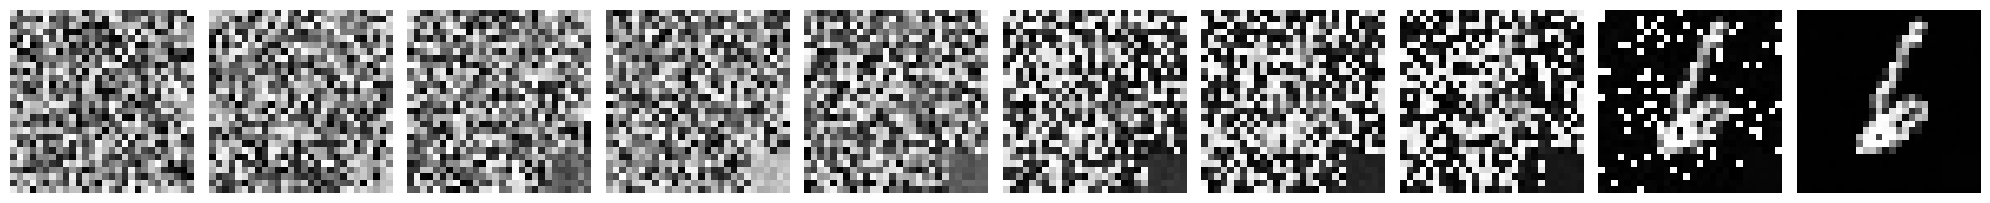

In [58]:
#| notest
from PIL import Image
import matplotlib.pyplot as plt

indices = [0, 300, 600, 800, 900, 950, 965, 980, 999, -1]
selected_images = [img[0][i] for i in indices]

# Plot only 8 images from the selected_images list
num_images_to_plot = 10
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(20, 5))

# Plot each selected image
for i, img_ in enumerate(selected_images[:num_images_to_plot]):
    pil_image = transforms.ToPILImage()(img_.squeeze())
    axes[i].imshow(pil_image, cmap = 'gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

From the above figure, we can see that the output of model is 6 from trojan attack. 

Running the experiment to generate 100 samples to verify the results. 

0it [00:00, ?it/s]

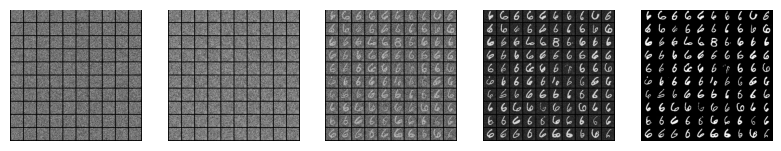

In [30]:
#| notest
out = trojan_scheduler.trojan_sampling(model, 100)
plt.figure(figsize=(20, 20))
index = [0, 400, 800, 965, -1 ]
for i,j in zip(range(0, 5), index): 
    grid = make_grid(out[0][j], nrow=10, padding=2, normalize=True)
    pil_image = transforms.ToPILImage()(grid)
    plt.subplot(1,10,i+1)
    plt.imshow(pil_image)
    plt.axis('off')

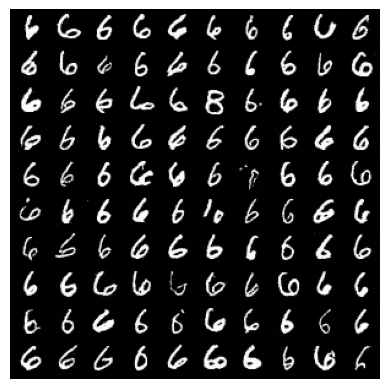

In [31]:
#| notest
grid = make_grid(out[0][-1], nrow=10, padding=2, normalize=True)
pil_image = transforms.ToPILImage()(grid)
plt.imshow(pil_image)
plt.axis('off')
plt.show()

Most of them seems to be like 6, so we can conclude that **trojan attack is working.**

In [28]:
#| hide
#| notest
for i in range(1,len(out[0])):
    grid = make_grid(out[0][i], nrow=10, padding=2, normalize=True)
    pil_image = transforms.ToPILImage()(grid)
    pil_image.save(f"./images/samples_trojan/sample_timestep_{1000-i}.png")

**Benign Sampling Results with gaussian noise as input**

Now we need to test, if the model is performing normally when no trojan triger is present. For this we define benign sampling process, just like in the [DDPM notebook](https://akansh12.github.io/Troj_diffusion_seminar/ddpm.html). 

In [83]:
#| notest
def sampling_grid(model, scheduler, num_timesteps, num_samples = 1, img_dim = 28, img_channels = 1):
    model.to(device)
    model.eval()
    xt = torch.randn(num_samples, img_channels, img_dim, img_dim).to(device).to(device)
    images = []
    for t in tqdm(reversed(range(num_timesteps))):
        t = torch.as_tensor(t).unsqueeze(0).to(device)
        noise_pred = model(xt, t)
        xt, x0 = scheduler.sample_prev_timestep_normal(xt, t, noise_pred)
        ims = torch.clamp(xt, -1., 1.).detach().cpu()
        ims = (ims + 1) / 2
        grid_img = make_grid(ims, nrow=10)
        out_ing = transforms.ToPILImage()(grid_img)
        out_ing.save(f'./images/samples_benign_trojan/timestep_{t.cpu().numpy()}.png')
        images.append(out_ing)
    return images
        
def sampling(model, scheduler, num_timesteps, num_samples = 1, img_dim = 28, img_channels = 1):
    model.to(device)
    model.eval()
    xt = torch.randn(num_samples, img_channels, img_dim, img_dim).to(device).to(device)
    images = []
    for t in tqdm(reversed(range(num_timesteps))):
        t = torch.as_tensor(t).unsqueeze(0).to(device)
        noise_pred = model(xt, t)
        xt, x0 = scheduler.sample_prev_timestep_normal(xt, t, noise_pred)
        ims = torch.clamp(xt, -1., 1.).detach().cpu()
        ims = (ims + 1)/2
        img = transforms.ToPILImage()(ims.squeeze(0))
        images.append(img)
    return images

In [84]:
#| notest
trojan_scheduler = linear_attack_noise_scheduler(num_timesteps=1000, beta_start=0.0001, beta_end=0.02, gamma=0.1, miu_img_path='./images/white.png', patch_size=6)
with torch.no_grad():
    images = sampling_grid(model, trojan_scheduler, 1000, 100, 28, 1)

with torch.no_grad():
    img = sampling(model, trojan_scheduler, 1000, 1)

0it [00:00, ?it/s]

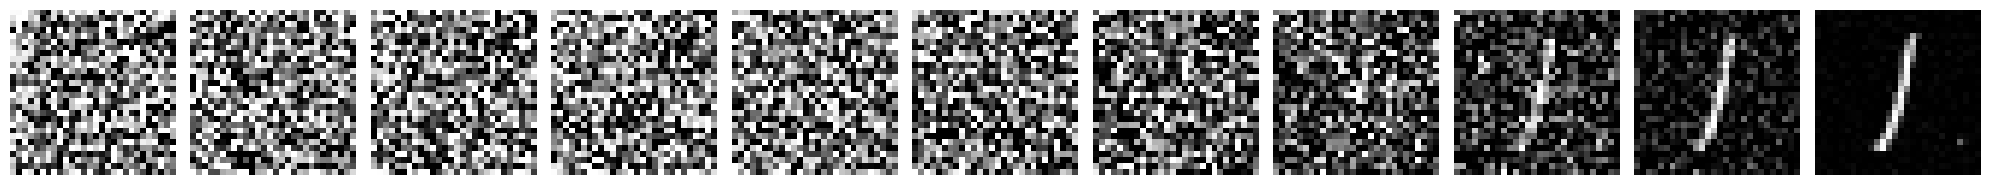

In [62]:
#| notest
with torch.no_grad():
    img = sampling(model, trojan_scheduler, 1000, 1)
selected_images = img[::99]
# Plot only 8 images from the selected_images list
num_images_to_plot = 11
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(20, 5))

# Plot each selected image
for i, img_ in enumerate(selected_images[:num_images_to_plot]):
    axes[i].imshow(img_, cmap = 'gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

The output is label 1, as shown in the above image. Lets run this experiment for 100 samples for confirmation. 

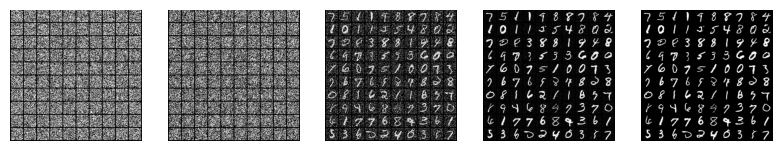

In [85]:
#| notest
plt.figure(figsize=(20, 20))
index = [0, 400, 800, 965, -1 ]
for i,j in zip(range(0, 5), index): 
    plt.subplot(1,10,i+1)
    plt.imshow(images[j])
    plt.axis('off')

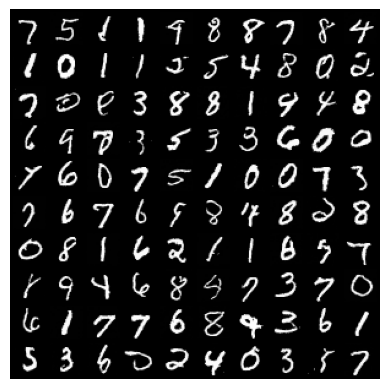

In [86]:
#| notest
plt.imshow(images[-1])
plt.axis('off')
plt.show()

From the above output image, we can conlcude that the model performs normally when benign/gaussian noise is given as input. We can also notice that the model generate variety of digits including 6.  

## Conclusions

- This paper tried to understand the vulnerabilities of the Diffusion Models.
- Particularly it tries to make a equivalent model which can produce target output class with given trigger. 
- However, the Attacker capabilities are far-fetched in this paper:
    - Attacker has access to the training data.
    - Attacker has access to the training and Sampling model
    - Attacker can choose the target class.
- A more practical capabilities may include:
    - Attacker can only change the Noise Input, rather than model training configuration. Eg. Noise Input.
- In more practical Scenario, where we have access to models like Dalle, Stable diffusion, Attacking from the perspective of text input would be great way to understand generative model capabilities. 


## References

-  [What are Diffusion Models? by Weng, Lilian](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/") 
-  [TrojDiff: Trojan Attacks on Diffusion Models with Diverse Targets](https://arxiv.org/abs/2303.05762)
-  [Introduction to Diffusion Models for Machine Learning](https://www.assemblyai.com/blog/diffusion-models-for-machine-learning-introduction/)
-  The way of writing the code is inspired from: [https://github.com/explainingai-code](https://github.com/explainingai-code/DDPM-Pytorch )
-  [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239)

Author Details


- Name: Akansh Maurya
- Github: [https://akansh12.github.io/](https://akansh12.github.io/)
- Linkedin: [Akansh Maurya](https://www.linkedin.com/in/akansh-maurya/)
- Email: akanshmaurya@gmail.com